In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
from losses import heteroscedastic_loss

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


ModuleNotFoundError: No module named 'losses'

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
tf.enable_eager_execution()

In [ ]:
%load_ext autoreload
%autoreload 2

# Data generator

In [136]:
def Likelihood(s,z,vartheta_par):
    if z == 0:
        s = 1-s
    f = s/sum(s)
    h = vartheta_par*f + (1-vartheta_par)*np.array([1/3,1/3,1/3])
    return h

def Posterior(lik,pre):
    out = (lik*pre)/sum(lik*pre)
    return out

def smoothVec(z,s,lambda_par,xi_par,omega0):
    omega = z*lambda_par*s + (1-z)*xi_par*(1-s) + (1 - (z*lambda_par + (1-z)*xi_par))*omega0
    return omega

def TransMat(o):
    G = np.diag(o)
    G[0][G[0]==0] = (1-o[0])/2
    G[1][G[1]==0] = (1-o[1])/2
    G[2][G[2]==0] = (1-o[2])/2
    return G

def ChapmanKolmogorov(G,posterior):
    p = np.inner(posterior,np.transpose(G))
    return p

def generative_model(lambda_par, xi_par, vartheta_par, M):
    
    # Initialize Vectors #
    max_trials = len(M)
    target_rule = np.zeros(max_trials, dtype=int) # Initialize the vector of correct rules
    correct_stimulus_card = np.zeros(max_trials, dtype=int) # Initialize the vector of correct stimulus cards
    x = np.zeros(max_trials, dtype=int) # Initialize the vector of the states (0: set-maintainance, 1: set-shifting)
    y = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's stimulus cards choice
    z = np.zeros(max_trials, dtype=int) # Initialize the vector of received feedback (1: correct, 0: error)
    s = np.zeros((max_trials,3), dtype=int) # Initialize the signal vector
    omega = np.zeros((max_trials,3)) # Initialize the vector of the attention to reward process
    pre = np.zeros((max_trials,3)) # Initialize the vector of the predictive (prior) probabilities
    lik = np.zeros((max_trials,3)) # Initialize the vector of likelihoods
    post = np.zeros((max_trials,3)) # Initialize the vector of posteriors
    target_rules_vector = np.tile(np.array([1,2,3]),20) # Vector of possible target rules
    
    # First Trial (the first correct response is given as in the standard version of Heaton's WCST) #
    i = 0 # Target rule indicator
    target_rule[0] = target_rules_vector[i] # Actual target rule
    correct_stimulus_card[0] = M[0][target_rule[0]-1] # Correct stimulus card
    pre[0] = np.array([1/3,1/3,1/3])
    x[0] = 2
    y[0] = M[0][x[0]-1] # Select the first correct stimulus card
    z[0] = int(y[0] == correct_stimulus_card[0]) # feedback
    s[0] = y[0] == M[0] # signal
    omega[0] = smoothVec(z[0],s[0],lambda_par,xi_par,np.array([0.5,0.5,0.5])) # Update omega
    lik[0] = Likelihood(s[0],z[0],vartheta_par)
    post[0] = Posterior(lik[0],pre[0])
    G = TransMat(omega[0])
    
    c = 0 # Initialize the stopping criterion
    for t in range(1,max_trials):
        target_rule[t] = target_rules_vector[i] # Current target rule
        correct_stimulus_card[t] = M[t][target_rule[t]-1] # Current correct stimulus card
        pre[t] = ChapmanKolmogorov(G, post[t-1]) # Compute predictive distribution
        x[t] = np.random.choice([1,2,3],1,p=pre[t]) # Sample the state (feature)
        y[t] = M[t][x[t]-1] # Choose sorting card
        z[t] = int(y[t] == correct_stimulus_card[t]) # feedback
        s[t] = y[t] == M[t] # signal
        omega[t] = smoothVec(z[t],s[t],lambda_par,xi_par,omega[t-1]) # Update omega
        lik[t] = Likelihood(s[t],z[t],vartheta_par) # Compute Likelihood of the observation given the states
        post[t] = Posterior(lik[t],pre[t]) # Compute posterior distribution over the hidden states
        G = TransMat(omega[t]) # Update Stability Matrix
        
        # Stopping condition (The task ends when the agent collects a series of 6 10 consecutive correct responses)
        if z[t] == 1:
            if z[t] == z[t-1]:
                c = c + 1
            else:
                c = 0
        if c == 9:
            i += 1
            c = 0
            
    return np.c_[z,y]

M = np.load('MatchingMat.npy') # Fixed Matching Matrix

def generate_data(batch_size, pbounds, to_tensor=True, M):
    """
    Generates a batch of parameters and data.
    """
    
    # Prepare data containers
    X = np.zeros((batch_size, n_trials, 2)).astype(np.float32)
    
    # Generate variable parameters
    lambdas = np.random.uniform(pbounds['lambda'][0], pbounds['lambda'][1], size=batch_size)
    xis = np.random.uniform(pbounds['xi'][0], pbounds['xi'][1], size=batch_size)
    
    theta = np.c_[lambdas, xis].astype(np.float32)
    
    # Generate fixed parameters
    alpha1s = np.array([15] * batch_size)
    beta1s = np.array([15] * batch_size)
    
    for bi in range(batch_size):

        
        # Generate data
        X_i = generative_model(lambdas[bi], xis[bi], 0.99, M)
        
        # Store data
        X[bi] = X_i
        
        if (bi+1) % 1000 == 0:
            print('Generated {} datasets.'.format(bi+1))
    
    X = np.concatenate((X, M), axis=-1)
    
    if to_tensor:
        X, theta = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(theta, dtype=tf.float32)
    return X, theta

# Train loop functions

In [82]:
def run_epoch_online(model, optimizer, data_gen, batch_size, iterations, 
              X_test, y_test, p_bar, transform=None, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for it in range(1, iterations+1):
            
        X_batch, y_batch = data_gen(batch_size)
        if transform is not None:
            X_batch, y_batch = transform(X_batch, y_batch)

        with tf.GradientTape() as tape:

            # Forward pass
            y_mean, y_var = model(X_batch)

            # Compute total loss
            loss = heteroscedastic_loss(y_batch, y_mean, y_var)

        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)

        # Validations score
        y_mean_val, y_var_val = model(X_test)
        train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
        val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
        val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)


        if clip_value is not None:
            gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        gradients = [tf.clip_by_value(grad, -5, 5) for grad in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("It:{0},Loss:{1:.3f},Val.Loss:{2:.3f},Rec.:{3:.3f},Val.Rec.:{4:.3f}".format(
        it, loss.numpy(), val_loss.numpy(), train_rec.numpy(), val_rec.numpy()))
        p_bar.update(1)
        
        
def run_epoch_offline(model, optimizer, dataset, X_test, y_test, p_bar, transform=None, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for bi, (X_batch, y_batch) in enumerate(dataset):
        
        if transform is not None:
            X_batch, y_batch = transform(X_batch, y_batch)

        with tf.GradientTape() as tape:

            # Forward pass
            y_mean, y_var = model(X_batch)

            # Compute total loss
            loss = heteroscedastic_loss(y_batch, y_mean, y_var)

        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)

        # Validations score
        y_mean_val, y_var_val = model(X_test)
        train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
        val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
        val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)


        if clip_value is not None:
            gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        gradients = [tf.clip_by_value(grad, -5, 5) for grad in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("Batch:{0},Loss:{1:.3f},Val.Loss:{2:.3f},Rec.:{3:.3f},Val.Rec.:{4:.3f}".format(
        bi+1, loss.numpy(), val_loss.numpy(), train_rec.numpy(), val_rec.numpy()))
        p_bar.update(1)

# Inference network

In [133]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units=128):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
    
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector


class InferenceNetwork(tf.keras.Model):
    
    def __init__(self, theta_dim, summary_dim=128):
        super(InferenceNetwork, self).__init__()
        

        # This will embed the categorical predictors
        self.embeddings = [tf.keras.layers.Dense(32) for _ in range(5)]
        
        
        # This model will then run through the concatenated embeddings
        self.lstm = tf.keras.layers.CuDNNLSTM(summary_dim, recurrent_initializer='glorot_uniform')
        
        # This model will predict the mean and variance of the distro
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(theta_dim * 2)
        ])
        
    def call(self, x):
        """Transforms the WCST data into a fixed size vector."""
        
        # Embed
        x = tf.concat([emb(x) for x, emb in zip(x, self.embeddings)], axis=-1)
        
        # Encode sequence
        x = self.lstm(x)
        
        # Pass through dense
        o = self.dense(x)
        mean_part, var_part = tf.split(o, 2, axis=-1)
        mean_part = tf.nn.sigmoid(mean_part)
        var_part = tf.nn.softplus(var_part)
        return mean_part, var_part
    
    
class InferenceConvNetwork(tf.keras.Model):
    
    def __init__(self, theta_dim, filters=32, summary_dim=128):
        super(InferenceConvNetwork, self).__init__()
        
        
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters, kernel_size=5, strides=1, activation='elu'),
            tf.keras.layers.Conv1D(filters, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 2, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 4, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 4, kernel_size=2, strides=2, activation='elu'),
            tf.keras.layers.Flatten()
        ])

#         self.embedding = tf.keras.layers.Dense(32, activation='relu')
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(theta_dim * 2)
        ])
        
    def call(self, x):
        """Transforms the WCST data into a fixed size vector."""
        
#         x = self.embedding(x)
        x = self.conv(x)
        
        # Pass through dense
        o = self.dense(x)
        mean_part, var_part = tf.split(o, 2, axis=-1)
        var_part = tf.nn.softplus(var_part)
        return mean_part, var_part

In [92]:
def plot_true_est_scatter(model, y_pred, y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()
    
    # Initialize figure

    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.ceil(len(param_names) / 2))
        n_row = 2
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot true vs estimated
        axarr[j].scatter(y_test[:, j], y_pred[:, j], color='black', alpha=0.4)
        
        # Plot AB line
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmse = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        nrmse = rmse / (y_pred[:, j].max() - y_test[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(y_pred[:, j], y_test[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('True')
            axarr[j].set_ylabel('Estimated')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig('figures/Splatter_scatter.png', dpi=600)
    
    plt.show()

In [93]:
def to_categorical(X_batch, theta_batch):
    """
    One-hot encodes all categorical entries except the first binary.
    """
    
    X_batch = [tf.convert_to_tensor(
                    tf.keras.utils.to_categorical(X_batch[:, :, i])
                ) if i !=0 else X_batch[:, :, 0:1]
                for i in range(X_batch.shape[2])]
    return X_batch, theta_batch

In [94]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch



In [95]:
def transform(X_batch, theta_batch, indices):
    
    X_batch, theta_batch = index_parameters(X_batch, theta_batch, indices)
    X_batch, theta_batch = to_categorical(X_batch, theta_batch)
    return X_batch, theta_batch

</p> We will test the following models:</p>

![title](sm.png)

# Initialization 

In [146]:
# --- Training hyperparameters --- #

#param_names = [r'$\lambda$', r'$\xi$']
param_names = [r'$\lambda$', r'$\xi$']

param_indices = [0, 1]

theta_dim = len(param_names)
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
epochs = 30
n_iterations = 1000
starter_learning_rate = 0.001
decay_steps = 9375
decay_rate = .95
n_test = 300
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
transform = partial(transform, indices=param_indices)

In [147]:
parameter_bounds = {
    'lambda': [0, 1],
    'xi': [0, 1],
}
data_gen = partial(generate_data, pbounds=parameter_bounds, M=M)

## Create a test set

In [154]:
%%time
X_test, theta_test = data_gen(n_test)
X_test, theta_test = transform(X_test, theta_test)

Wall time: 9.85 s


## Create a development set

In [148]:
X_train4_nolog_nok, theta_train4_nolog_nok = data_gen(50000, to_tensor=False)
np.save('X4_nolog_nok.npy', X_train4_nolog_nok)
np.save('theta4_nolog_nok.npy', theta_train4_nolog_nok)
#X_train4, theta_train4 = np.load('X4_nolog.npy'), np.load('theta4_nolog.npy')

Generated 1000 datasets.
Generated 2000 datasets.
Generated 3000 datasets.
Generated 4000 datasets.
Generated 5000 datasets.
Generated 6000 datasets.
Generated 7000 datasets.
Generated 8000 datasets.
Generated 9000 datasets.
Generated 10000 datasets.
Generated 11000 datasets.
Generated 12000 datasets.
Generated 13000 datasets.
Generated 14000 datasets.
Generated 15000 datasets.
Generated 16000 datasets.
Generated 17000 datasets.
Generated 18000 datasets.
Generated 19000 datasets.
Generated 20000 datasets.
Generated 21000 datasets.
Generated 22000 datasets.
Generated 23000 datasets.
Generated 24000 datasets.
Generated 25000 datasets.
Generated 26000 datasets.
Generated 27000 datasets.
Generated 28000 datasets.
Generated 29000 datasets.
Generated 30000 datasets.
Generated 31000 datasets.
Generated 32000 datasets.
Generated 33000 datasets.
Generated 34000 datasets.
Generated 35000 datasets.
Generated 36000 datasets.
Generated 37000 datasets.
Generated 38000 datasets.
Generated 39000 datas

In [150]:
dataset = tf.data.Dataset.from_tensor_slices((X_train4_nolog_nok, theta_train4_nolog_nok)).shuffle(X_train4_nolog_nok.shape[0]).batch(batch_size)

## Create networks and dataset

In [151]:
model = InferenceNetwork(theta_dim)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [152]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


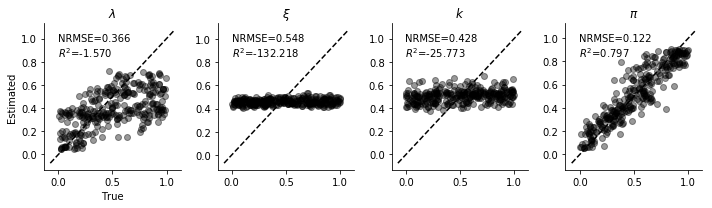

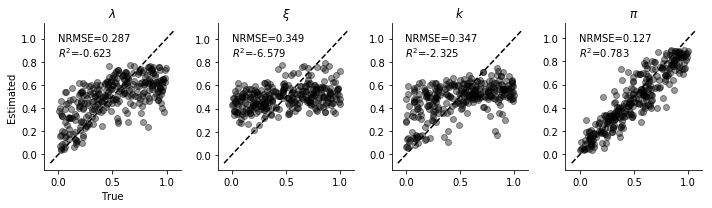

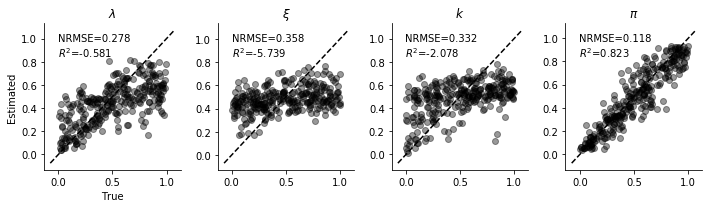

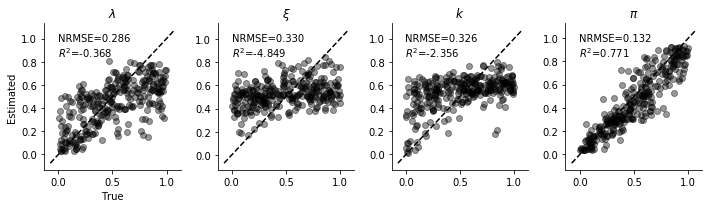

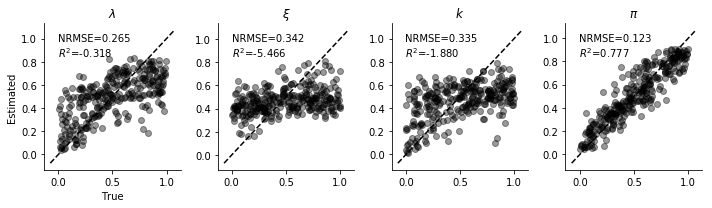

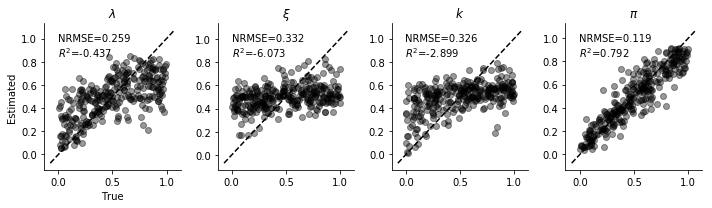

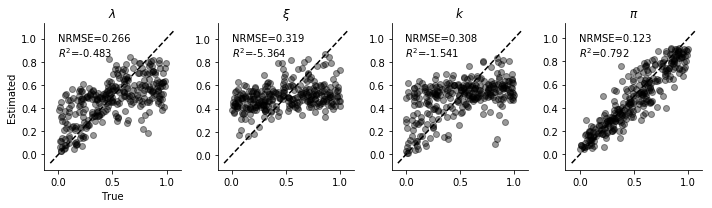

KeyboardInterrupt: 

In [155]:
for ep in range(1, epochs+1):
    
    with tqdm(total = (X_train4.shape[0] // batch_size), desc='Epoch {0}, Lr. {1:.4f}'.format(ep, learning_rate())) as p_bar:
        
        # Run epoch offline (with dev set)
        run_epoch_offline(model, optimizer, dataset, X_test, theta_test, p_bar, 
                          transform=transform, global_step=global_step, clip_value=clip_value)
        
        # Predict test
        theta_pred_test = model(X_test)[0]
        plot_true_est_scatter(model, theta_pred_test, theta_test, 
                              param_names, figsize=(10, 3), filename=None)
        
        # Save after each chunk
        manager.save()

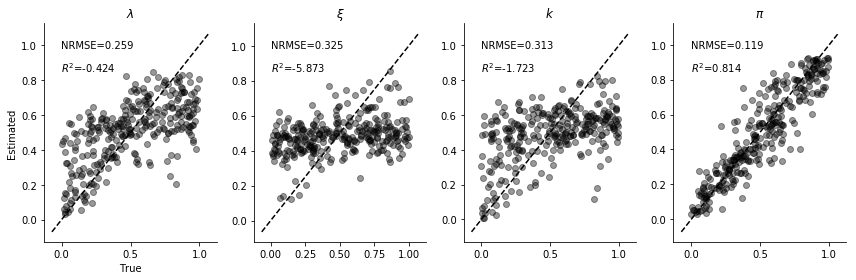

In [156]:
# Predict test
theta_pred_test = model(X_test)[0]
plot_true_est_scatter(model, theta_pred_test, theta_test, 
                      param_names, figsize=(12, 4), filename=None)